In [1]:
import bs4
from urllib.request import urlopen

In [2]:
url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=005930'     
# Floating ratio from Naver
url_float

'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=005930'

In [3]:
source = urlopen(url_float).read()
soup = bs4.BeautifulSoup(source, 'lxml')

//*[@id="cTB11"]/tbody/tr[7]/td

In [4]:
soup.find(id='cTB11').find_all('tr')[6].td.text

'\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t128,386,494주 / 72.78%\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t'

In [5]:
tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
tmp = tmp.replace('\r', '')
tmp = tmp.replace('\n', '')
tmp = tmp.replace('\t', '')
tmp

'128,386,494주 / 72.78%'

In [6]:
import re

In [7]:
tmp = re.split('/', tmp)
tmp

['128,386,494주 ', ' 72.78%']

In [8]:
tmp[0]

'128,386,494주 '

In [9]:
tmp[1]

' 72.78%'

In [10]:
outstanding = tmp[0].replace(',', '')
outstanding = outstanding.replace('주', '')
outstanding = outstanding.replace(' ', '')
outstanding

'128386494'

In [11]:
floating = tmp[1].replace(' ', '')
floating = floating.replace('%', '')
floating

'72.78'

In [12]:
outstanding = int(outstanding)
outstanding

128386494

In [13]:
floating = float(floating)
floating

72.78

In [14]:
# 구성종목 기본정보
def stock_info(stock_cd):
    url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + stock_cd
    source = urlopen(url_float).read()
    soup = bs4.BeautifulSoup(source, 'lxml')
    
    tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
    tmp = tmp.replace('\r', '')
    tmp = tmp.replace('\n', '')
    tmp = tmp.replace('\t', '')
    
    tmp = re.split('/', tmp)

    outstanding = tmp[0].replace(',', '')
    outstanding = outstanding.replace('주', '')
    outstanding = outstanding.replace(' ', '')
    outstanding = int(outstanding)

    floating = tmp[1].replace(' ', '')
    floating = floating.replace('%', '')
    floating = float(floating)
    
    name = soup.find(id='pArea').find('div').find('div').find('tr').find('td').find('span').text
    
    k10_outstanding[stock_cd] = outstanding
    k10_floating[stock_cd] = floating
    k10_name[stock_cd] = name

In [15]:
'''
한국거래소 시가총액 상위 10종목 (2018년4월9일 기준)
005930	삼성전자
000660	SK하이닉스
068270	셀트리온
207940	삼성바이오로직스
005380	현대차
005490	POSCO
051910	LG화학
028260	삼성물산
035420	NAVER
012330	현대모비스
'''
k10_component = ['005930', '000660', '068270', '207940', '005380',\
                 '005490', '051910', '028260', '035420', '012330']

In [16]:
k10_outstanding = dict()
k10_floating = dict()
k10_name = dict()
for stock_cd in k10_component:
    stock_info(stock_cd)

In [17]:
k10_outstanding

{'000660': 728002365,
 '005380': 220276479,
 '005490': 87186835,
 '005930': 128386494,
 '012330': 97343863,
 '028260': 189690043,
 '035420': 32962679,
 '051910': 70592343,
 '068270': 125108377,
 '207940': 66165000}

In [18]:
k10_floating

{'000660': 76.91,
 '005380': 65.76,
 '005490': 79.26,
 '005930': 72.78,
 '012330': 67.12,
 '028260': 47.81,
 '035420': 77.87,
 '051910': 64.28,
 '068270': 63.27,
 '207940': 21.77}

과거 주가 구하기 

In [19]:
import datetime as dt
import pandas as pd

In [20]:
def date_format(d):
    d = str(d).replace('-', '.')
    
    yyyy = int(d.split('.')[0]) 
    mm = int(d.split('.')[1])
    dd = int(d.split('.')[2])

    this_date= dt.date(yyyy, mm, dd)
    return this_date

In [21]:
def historical_stock_naver(stock_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:   # start_date가 있으면
        start_date = date_format(start_date)   # date 포맷으로 변환
    else:    # 없으면
        start_date = dt.date.today()   # 오늘 날짜를 지정
    if end_date:   # end_date가 없으면 
        end_date = date_format(end_date)   # date 포맷으로 변환
    else:   # end_date가 있으면
        end_date = dt.date.today()   # 오늘 날짜를 end_date로 지정
        
    naver_stock = 'http://finance.naver.com/item/sise_day.nhn?code=' + stock_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_stock).read()
    source = bs4.BeautifulSoup(source, 'lxml')
    
    dates = source.find_all('span', class_='tah p10 gray03')   # 날짜 수집   
    prices = source.find_all('td', class_='num')   # 종가 수집
    
    for n in range(len(dates)):
    
        if len(dates) > 0:
            
            # 날짜 처리
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*6].text
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                              
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find_all('table')[1].find('td', class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = float(last_page)
        
    # 다음 페이지 호출
    if page_n < last_page:
        page_n = page_n + 1
        historical_stock_naver(stock_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices  

In [22]:
k10_historical_prices = dict()

for stock_cd in k10_component:
    
    historical_prices = dict()
    start_date = '2017-1-1'
    end_date = '2017-12-31'
    historical_stock_naver(stock_cd, start_date, end_date)
    
    k10_historical_prices[stock_cd] = historical_prices

In [23]:
k10_historical_price = pd.DataFrame(k10_historical_prices)

In [24]:
k10_historical_price = k10_historical_price.fillna(method='ffill')
if k10_historical_price.isnull().values.any():
    k10_historical_price = k10_historical_price.fillna(method='bfill')
k10_historical_price.head(3)

,000660,005380,005490,005930,012330,028260,035420,051910,068270,207940
2017-01-02,45800.0,150000.0,260500.0,1805000.0,271500.0,125500.0,777000.0,253000.0,108200.0,156500.0
2017-01-03,47250.0,153000.0,256000.0,1824000.0,275500.0,129000.0,767000.0,262000.0,106600.0,158000.0
2017-01-04,46500.0,154000.0,254500.0,1808000.0,276000.0,129000.0,810000.0,268500.0,106100.0,154500.0


지수 산출을 위한 계산

In [25]:
tmp = {'Outstanding' : k10_outstanding,\
       'Floating' : k10_floating,\
       'Price' : k10_historical_price.iloc[0],\
       'Name' : k10_name}
k10_info = pd.DataFrame(tmp)

In [26]:
k10_info['f Market Cap'] = k10_info['Outstanding'] * k10_info['Floating'] * k10_info['Price'] * 0.01
k10_info['Market Cap'] = k10_info['Outstanding'] * k10_info['Price'] * 0.01
k10_info

,Floating,Name,Outstanding,Price,f Market Cap,Market Cap
000660,76.91,SK하이닉스,728002365,45800.0,2.564372e+13,3.334251e+11
005380,65.76,현대차,220276479,150000.0,2.172807e+13,3.304147e+11
005490,79.26,POSCO,87186835,260500.0,1.800167e+13,2.271217e+11
005930,72.78,삼성전자,128386494,1805000.0,1.686586e+14,2.317376e+12
012330,67.12,현대모비스,97343863,271500.0,1.773905e+13,2.642886e+11
028260,47.81,삼성물산,189690043,125500.0,1.138170e+13,2.380610e+11
035420,77.87,NAVER,32962679,777000.0,1.994407e+13,2.561200e+11
051910,64.28,LG화학,70592343,253000.0,1.148032e+13,1.785986e+11
068270,63.27,셀트리온,125108377,108200.0,8.564687e+12,1.353673e+11
207940,21.77,삼성바이오로직스,66165000,156500.0,2.254245e+12,1.035482e+11


In [27]:
k10_historical_mc = k10_historical_price * k10_info['Outstanding'] * k10_info['Floating'] * 0.01
k10_historical_mc.head(3)

,000660,005380,005490,005930,012330,028260,035420,051910,068270,207940
2017-01-02,2.564372e+13,2.172807e+13,1.800167e+13,1.686586e+14,1.773905e+13,1.138170e+13,1.994407e+13,1.148032e+13,8.564687e+12,2.254245e+12
2017-01-03,2.645559e+13,2.216263e+13,1.769070e+13,1.704340e+14,1.800040e+13,1.169911e+13,1.968739e+13,1.188871e+13,8.438037e+12,2.275851e+12
2017-01-04,2.603566e+13,2.230749e+13,1.758704e+13,1.689390e+14,1.803307e+13,1.169911e+13,2.079111e+13,1.218366e+13,8.398459e+12,2.225437e+12


In [28]:
'''
<데이터프레임>.sum() 은 각 열의 합 (세로방향)
<데이터프레임>.sum(axis=1) 은 각 행의 합 (가로방향)
'''
k10_historical_mc.sum(axis=1)     # 일자별 시가총액 합

2017-01-02    3.053962e+14
2017-01-03    3.087324e+14
2017-01-04    3.082000e+14
2017-01-05    3.048298e+14
2017-01-06    3.078366e+14
2017-01-09    3.123200e+14
2017-01-10    3.135042e+14
2017-01-11    3.208485e+14
2017-01-12    3.231974e+14
2017-01-13    3.166125e+14
2017-01-16    3.122710e+14
2017-01-17    3.136861e+14
2017-01-18    3.131433e+14
2017-01-19    3.164365e+14
2017-01-20    3.137866e+14
2017-01-23    3.173002e+14
2017-01-24    3.176785e+14
2017-01-25    3.224184e+14
2017-01-26    3.266520e+14
2017-01-31    3.221921e+14
2017-02-01    3.223651e+14
2017-02-02    3.220885e+14
2017-02-03    3.230807e+14
2017-02-06    3.231988e+14
2017-02-07    3.207752e+14
2017-02-08    3.190117e+14
2017-02-09    3.178375e+14
2017-02-10    3.174755e+14
2017-02-13    3.158541e+14
2017-02-14    3.126760e+14
                  ...     
2017-11-16    4.432496e+14
2017-11-17    4.432924e+14
2017-11-20    4.396765e+14
2017-11-21    4.421185e+14
2017-11-22    4.453455e+14
2017-11-23    4.425039e+14
2

In [29]:
k10 = pd.DataFrame()
k10['K10 Market Cap'] = k10_historical_mc.sum(axis=1)
k10.head(3)

,K10 Market Cap
2017-01-02,3.053962e+14
2017-01-03,3.087324e+14
2017-01-04,3.082000e+14


In [30]:
k10['K10'] = k10['K10 Market Cap'] / k10['K10 Market Cap'][0] * 100
k10.head(3)

,K10 Market Cap,K10
2017-01-02,3.053962e+14,100.000000
2017-01-03,3.087324e+14,101.092432
2017-01-04,3.082000e+14,100.918095


K10 지수 그래프 그리기

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

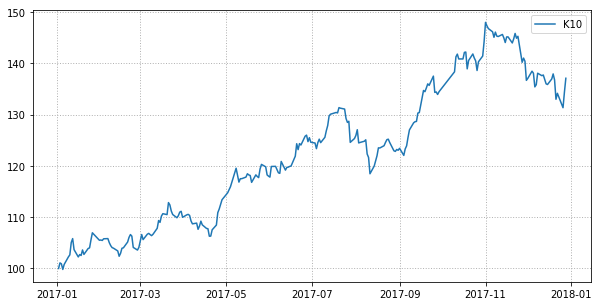

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(k10['K10'])
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

KOSPI200과의 비교

In [33]:
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    index_cd = index_cd   # 인덱스 코드 
    page_n = page_n   # 페이지 번호 
    
    if start_date:   # start_date가 있으면
        start_date = date_format(start_date)   # date 포맷으로 변환
    else:    # 없으면
        start_date = dt.date.today()   # 오늘 날짜를 지정
    if not end_date:   # end_date가 없으면 
        end_date = dt.date.today()   # 오늘 날짜를 end_date로 지정
    else:   # end_date가 있으면
        end_date = date_format(end_date)   # date 포맷으로 변환
        
    naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_index).read()   # 지정한 페이지에서 코드 읽기
    source = bs4.BeautifulSoup(source, 'lxml')   # 뷰티풀 스프로 태그별로 코드 분류
    
    dates = source.find_all('td', class_='date')   # <td class="date">태그에서 날짜 수집   
    prices = source.find_all('td', class_='number_1')   # <td class="number_1">태그에서 지수 수집
    
    for n in range(len(dates)):
    
        if dates[n].text.split('.')[0].isdigit():
            
            # 날짜 처리
            this_date = dates[n].text
            this_date= date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*4].text   # prices 중 종가지수인 0,4,8,...번째 데이터 추출
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices           
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        # 마지막페이지 주소 추출
        last_page = last_page.split('&')[1]   # & 뒤의 page=506 부분 추출
        last_page = last_page.split('=')[1]   # = 뒤의 페이지번호만 추출
        last_page = int(last_page)   # 숫자형 변수로 변환
        
    # 다음 페이지 호출
    if page_n < last_page:   
        page_n = page_n + 1   
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices  

In [34]:
historical_prices = dict()     # 딕셔너리 초기화
kospi200 = historical_index_naver('KPI200', '2017-1-1', '2017-12-31')
kospi200

{datetime.date(2017, 1, 2): 260.36,
 datetime.date(2017, 1, 3): 262.97,
 datetime.date(2017, 1, 4): 263.12,
 datetime.date(2017, 1, 5): 261.98,
 datetime.date(2017, 1, 6): 263.2,
 datetime.date(2017, 1, 9): 263.74,
 datetime.date(2017, 1, 10): 263.73,
 datetime.date(2017, 1, 11): 268.15,
 datetime.date(2017, 1, 12): 269.95,
 datetime.date(2017, 1, 13): 267.91,
 datetime.date(2017, 1, 16): 266.15,
 datetime.date(2017, 1, 17): 267.37,
 datetime.date(2017, 1, 18): 267.08,
 datetime.date(2017, 1, 19): 267.7,
 datetime.date(2017, 1, 20): 266.52,
 datetime.date(2017, 1, 23): 267.12,
 datetime.date(2017, 1, 24): 267.3,
 datetime.date(2017, 1, 25): 268.15,
 datetime.date(2017, 1, 26): 270.48,
 datetime.date(2017, 1, 31): 268.09,
 datetime.date(2017, 2, 1): 269.56,
 datetime.date(2017, 2, 2): 268.49,
 datetime.date(2017, 2, 3): 268.85,
 datetime.date(2017, 2, 6): 269.49,
 datetime.date(2017, 2, 7): 268.97,
 datetime.date(2017, 2, 8): 267.72,
 datetime.date(2017, 2, 9): 267.69,
 datetime.date(20

In [35]:
k200 = pd.DataFrame({'K200' : kospi200})
k200.head(3)

,K200
2017-01-02,260.36
2017-01-03,262.97
2017-01-04,263.12


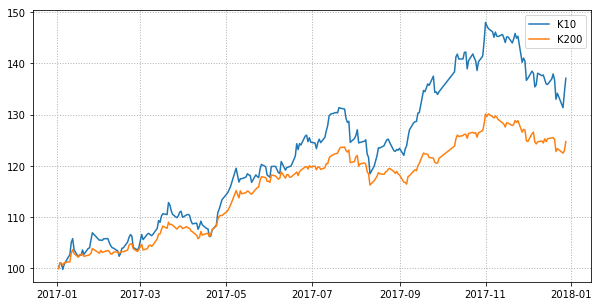

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(k10['K10'] / k10['K10'][0] * 100)
plt.plot(k200['K200'] / k200['K200'][0] * 100)
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

# K10 선물가격 산출

In [37]:
import math

F = Se^(r-d)t

In [38]:
def futures_price (S, r, d, T, t0):
    t = (T - t0).days / 252
    F = S * math.exp((r-d)*t)
    return F

In [39]:
T = dt.date(2018, 12, 14)     # 만기일
t0 = dt.date(2018, 6, 15)     # 현재일

futures_price (100.0, 0.02, 0.015, T, t0)

100.36176390281524

In [40]:
T = dt.date(2018, 12, 14)     # 만기일
t0 = dt.date(2018, 12, 10)     # 현재일

futures_price (100.0, 0.02, 0.015, T, t0)

100.00793682288563